/home/connor/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


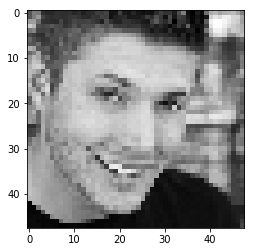

(1, 48, 48, 1)


/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide
/home/connor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide


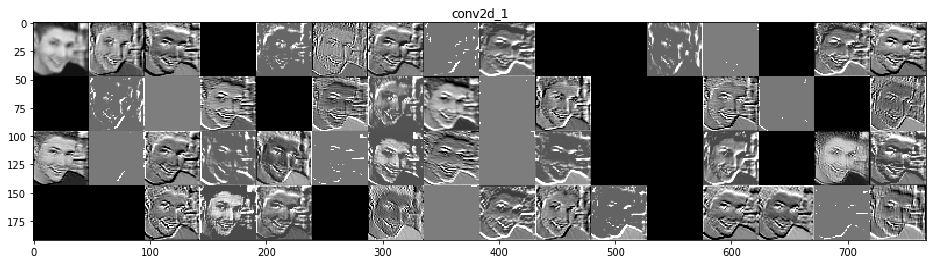

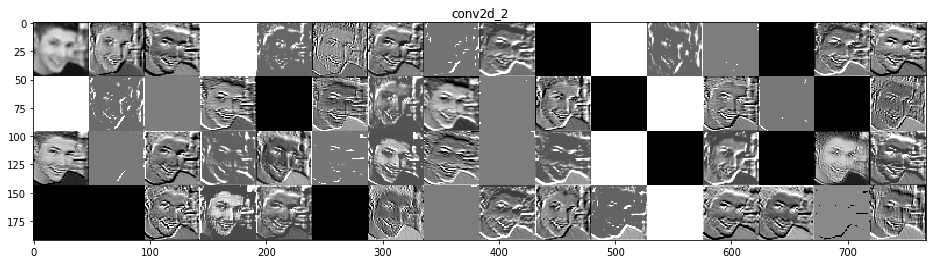

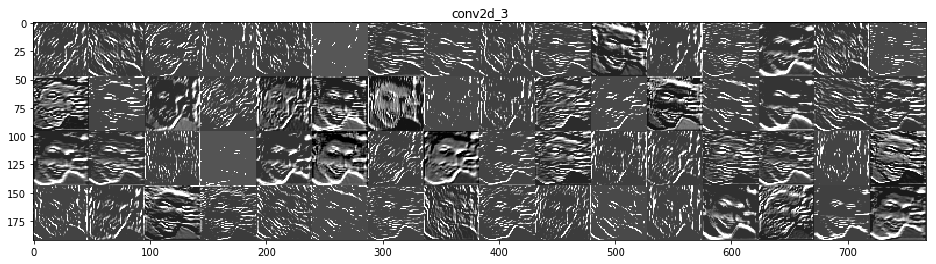

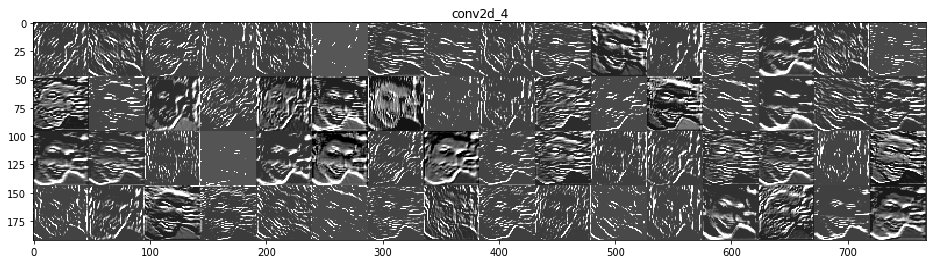

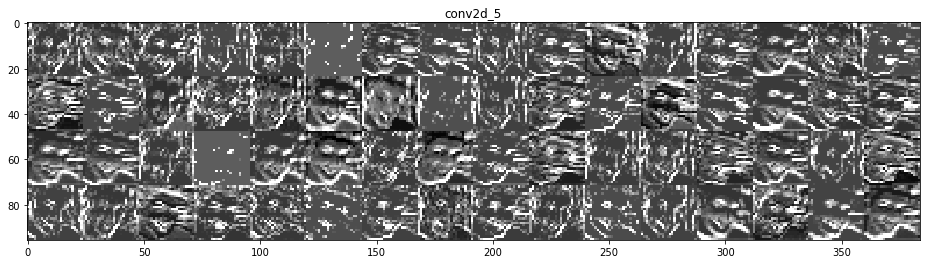

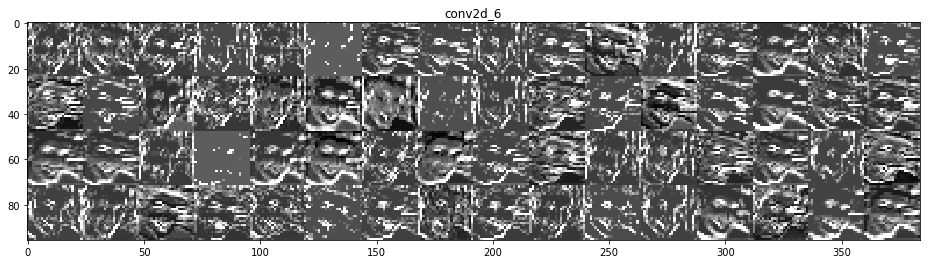

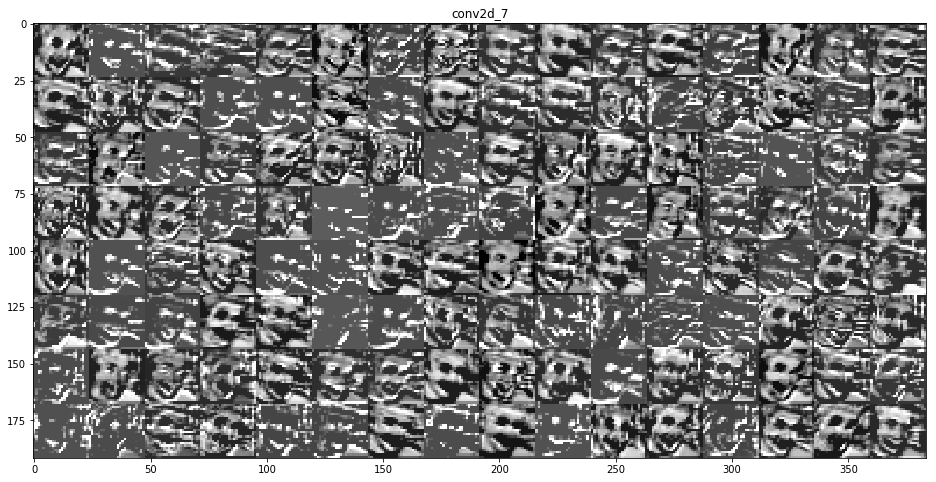

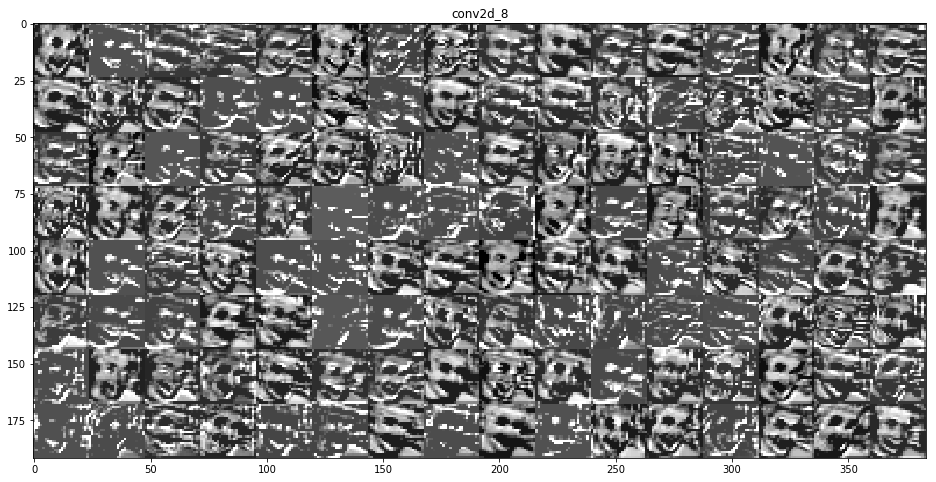

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import os
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, ZeroPadding2D
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.preprocessing import image
from keras import models

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        #a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    #plt.savefig("/home/connor/4thYear/Dissertation/thesis/images/filters_and_features/filters1.png", bbox_inches='tight')
    plt.show()

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) 
set_session(sess)

img_path = "../images/AffectNet/ManuallyAnnotated/Manually_Annotated_Images/2/f47e83544cf4f3d05ed9ee7d8ec1984d3ddc59bd77df9a24bbab3bad.jpg"
img = image.load_img(img_path, target_size=(48, 48), grayscale=True)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(np.squeeze(img_tensor),cmap='gray')
plt.show()

print(img_tensor.shape)

classifier = load_model('../models/MODEL_Turkey6_aug.h5')

images = []
for i in range(64):
    a = classifier.layers[0].get_weights()[0][:, :, :, i].squeeze()
    images.append(a)
show_images(images, cols=4)

layer_outputs = [layer.output for layer in classifier.layers] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=classifier.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation

layer_names = []
for layer in classifier.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
layer_names = ["conv2d_1","conv2d_2","conv2d_3","conv2d_4","conv2d_5","conv2d_6",
              "conv2d_7", "conv2d_8"]
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')